# Processing the 2-D NMR data
```{eval-rst}
.. currentmodule:: mab_utils
```

## Imports

In [15]:
# Python modules for numerics and scientific computing
import numpy as np
import pandas as pd

# scikit-learn

# Matplotlib
%matplotlib inline
import pickle

import mab_utils
import matplotlib
import plot_utils as plu

# import tqdm
import interlab as inl

## Data Scaling

Here, we define the contour lines that are used for contour mapping, and also the scaling function that will scale the NMR intensity map into a suitable function for interlab

In [2]:
# Contours for contour mapping
# Contours go from 2.5 to 35 in logarithmic steps of 1.3 (i.e. 2.5, 2.5*1.3, 2.5*1.69, ...)
contoursp = 2.5 * 1.3 ** np.arange(0, 11)
contoursn = -2.5 * 1.3 ** np.arange(0, 11)[::-1]
ssi_contours = np.concatenate((contoursn, contoursp))

# Parameters that will be used for the piecewise linear interpolation
mid = 0.5
crush_point = 0.05
crush_lo = mid - crush_point
crush_hi = mid + crush_point

# Piecewise-linear interpolation function for mapping
# Data  will be mapped FROM NMR intensity TO 0-to-1 color scale
interp_map = (
    [ssi_contours.min(), contoursn.max(), 1e-15, contoursp.min(), ssi_contours.max()],
    [0, crush_lo, mid, crush_hi, 1],
)

# Greyscale conversion function
greyscale_conversion = [0.3, 0.59, 0.11, 0]

# Colormap for normalization
im = matplotlib.cm.ScalarMappable(
    cmap=mab_utils.RdBu_with_black.reversed(),
)
# Needs to be reversed because red is positive, but we want red to be negative
cm = im.get_cmap()

In [3]:
# Shape of the data in release3
windowed_shape = (735, 819)
nmr_window_region = [1.9, -0.9, 9, 30.5]  # in units of ppm

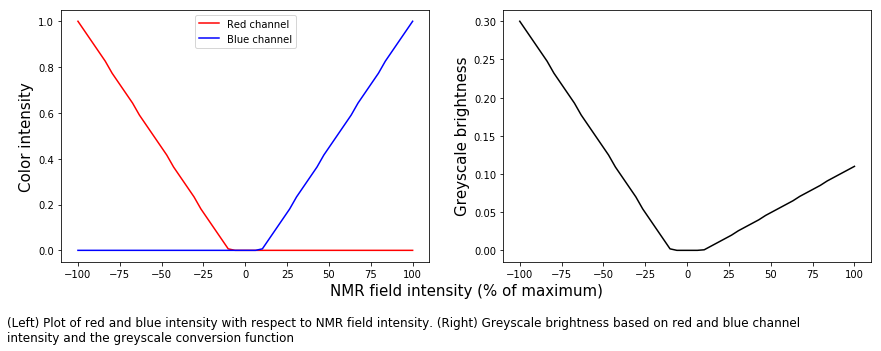

In [4]:
plotsize = (6, 4)

fig, axes = plu.make_grid_plot(
    1, 2, plotsize=plotsize, xlabel="NMR field intensity (% of maximum)"
)

# Create a vector of values at which to evaluate the colormap
cmap_range = np.linspace(0, 1)
colormap_values = cm(cmap_range)
grey_values = np.dot(greyscale_conversion, colormap_values.T)

# Mapping from colormap space to NMR intensity space
nmr_intensity = 100 * (2 * cmap_range - 1)


axes.flatten()[0].plot(
    nmr_intensity,
    colormap_values[:, 0],
    "r",
    label="Red channel",
)
axes.flatten()[0].plot(
    nmr_intensity,
    colormap_values[:, 2],
    "b",
    label="Blue channel",
)

axes.flatten()[0].set_ylabel("Color intensity", size=15)
axes.flatten()[0].legend()

axes.flatten()[1].plot(
    nmr_intensity,
    grey_values,
    "k",
)
axes.flatten()[1].set_ylabel("Greyscale brightness", size=15)

caption_text = (
    "(Left) Plot of red and blue intensity with respect to NMR "
    + "field intensity. (Right) Greyscale brightness based on red and blue channel\n"
    + "intensity and the greyscale conversion function"
)

width, height = fig.get_size_inches()

t = fig.text(0, -0.25 / height, caption_text, size=12, va="top")

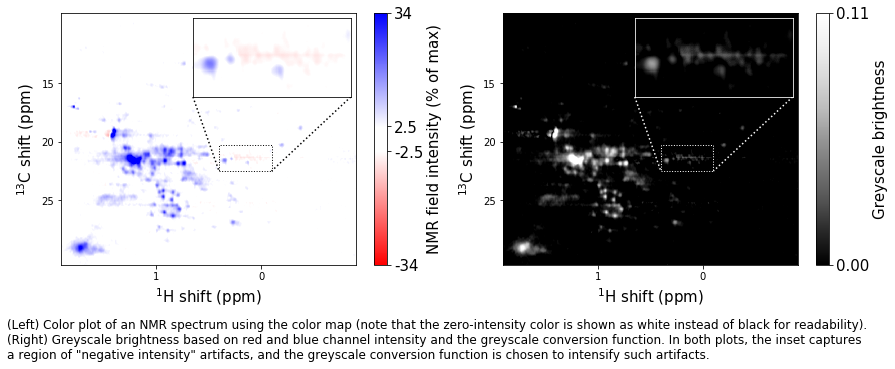

In [5]:
normalization_colormap = mab_utils.RdBu_with_white.reversed()

im = matplotlib.cm.ScalarMappable(
    cmap=normalization_colormap,
)
cma = im.get_cmap()
cm_inset = im.get_cmap()
cma = cm

plotsize = (6, 4)

inset_start_x = 0.4
inset_width = -0.5
inset_start_y = 22.5
inset_height = -2.25

file = "./release3/new_ext/089-D2C-S-U-600-1894-104-37C.ft2"

fig, axes = plu.make_grid_plot(1, 2, plotsize=plotsize)  # plt.subplots(figsize=(6,4))
mab_utils.nmr_color_scaled(
    file,
    fig,
    axes,
    cm_inset,
    cm,
    extent=nmr_window_region,
    inset_start=(inset_start_x, inset_start_y),
    inset_width=inset_width,
    inset_height=inset_height,
    colormap_spine_color="k",
    shape=windowed_shape,
    interp_map=interp_map,
)

# fig,axes=plu.make_grid_plot(1,2,plotsize=plotsize)#plt.subplots(figsize=(6,4))
# mab_utils.nmr_color_scaled(file,fig,axes,cm,cm,extent=[1.9,-0.9,9,30.5],
#                            inset_start=(inset_start_x,inset_start_y),
#                            inset_width=inset_width,inset_height=inset_height,
#                            colormap_spine_color='w',
#                            shape=windowed_shape,interp_map=interp_map,
#                           )

caption_text = (
    "(Left) Color plot of an NMR spectrum using the color map (note that "
    + "the zero-intensity color is shown as white instead of black for "
    + "readability). \n(Right) Greyscale brightness based on red and blue "
    + "channel intensity and the greyscale conversion function. In both plots, "
    + 'the inset captures \na region of "negative intensity" artifacts, and '
    + "the greyscale conversion function is chosen to intensify such artifacts."
)

width, height = fig.get_size_inches()

t = fig.text(0, -0.25 / height, caption_text, size=12, va="top")

## Reading data and metadata

Read the spectral metadata table and load it into a pandas dataframe. 

```{eval-rst}
.. autofunction:: mab_utils.read_all_metadata
```

In [6]:
metadata_table = mab_utils.read_all_metadata(
    metadata_file="release3/meta.tab", raw_data_path="./release3/new_ext/"
)

/home/local/NIST/dsheen/nistmab/mab_utils.py:118: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  comment='#',


In [7]:
expert_scores_table = pd.read_csv(
    "release3/score.tab", skiprows=3, header=None, delim_whitespace=True
)
# Extract score values from the scores table
expert_scores = expert_scores_table[0].values
# Find nonzero scores
match_expert = np.array([score > 0 for score in expert_scores_table[0].values])
metadata_table["ExptScore"] = expert_scores

In [8]:
metadata_table.head()

,INDEX,DIR_NAME,CODE,TITLE,ExpType,ExpCode,File,ExptScore
0,1,8822,8822-010,D2C-S-U-900-8822-010-37C,800,D2C-S,./release3/new_ext/001-D2C-S-U-900-8822-010-37...,0
1,2,7425,7425-010,D2A-S-U-900-7425-010-37C,800,D2A-S,./release3/new_ext/002-D2A-S-U-900-7425-010-37...,0
2,3,7425,7425-012,D2C-S-U-900-7425-012-37C,800,D2C-S,./release3/new_ext/003-D2C-S-U-900-7425-012-37...,0
3,4,7425,7425-015,D3A-F-U-900-7425-015-37C,800,D3A-F,./release3/new_ext/004-D3A-F-U-900-7425-015-37...,0
4,5,8495,8495-010,D2A-S-U-900-8495-010-37C,800,D2A-S,./release3/new_ext/005-D2A-S-U-900-8495-010-37...,0


Read the raw spectral data into a dictionary, along with the spectral titles.

```{eval-rst}
.. autofunction:: mab_utils.read_all_data
```

In [9]:
# Indices to split by
full_indices = ["ExpCode", "ExpType", "DIR_NAME"]
split_point = (
    2  # This means ExpCode and ExpType will form the keys that will split the data
)

fulldata, full_data_dict, titles_dict = mab_utils.read_all_data(
    metadata_table, full_indices, split_point, shape=windowed_shape
)

## Processing the data

Process the raw spectral data using the color map and the greyscale conversion function.

In [10]:
# Empty container
data_dict = dict()
thresh = 0
# Not actually using a threshold, but keep it in the code logic in case we decide later

for description, nmrdata in full_data_dict.items():
    nmrprocessed = []
    for rawdata in nmrdata:
        # Crush values below threshold to 0
        data = np.zeros_like(rawdata)
        data[np.abs(rawdata) > thresh] = rawdata[np.abs(rawdata) > thresh]

        # Convert to colormap and greyscale-equivalent
        data, data_colors = mab_utils.colorize(data, interp_map, cm)

        # Check for zero and negative values
        data = inl.fix_spectrum(data)

        data = data / data.sum()  # Sum-normalize

        # np.dot spits out a 1-D vector, need to add another axis
        nmrprocessed += [data[:, np.newaxis]]
    nmrprocessed = np.concatenate(nmrprocessed, axis=1).T
    data_dict[description] = nmrprocessed

## Preparing the interlab_py analysis

### Create the interlab_py project object

Create the interlab_py object, as described in [Sheen, et al.](https://doi.org/10.1016/j.chemolab.2016.12.010)

In [11]:
exp_keys = list(titles_dict.keys())

jeffries = r"Symmetric Kullback-Liebler"

nmr_distance_metrics = [
    dict(metric=r"Hellinger", function=inl.metrics.hellinger_hyp),
    dict(metric=jeffries, function=inl.metrics.jeffries),
]

mab_project = inl.Project(
    distance_metrics=nmr_distance_metrics,
    Sample_names=exp_keys,
    Data_set_names=titles_dict,
    data=data_dict,
    rawdata=full_data_dict,
)

Group E1-F-600 has fewer than 3 measurements, not creating
Group E1-F-800 has fewer than 3 measurements, not creating
Group E1A-F-800 has fewer than 3 measurements, not creating
Group E1C-S-800 has fewer than 3 measurements, not creating


### Calculate interspectral distances

Pairwise interspectral distance is calculated using the symmetric Kullback-Liebler divergence,

$$
d_{SKL}(x,y) = \frac{1}{2} \left( \sum_{i} \left( x_i - y_i \right) \log \frac{x_i}{y_i}  \right)
$$
where $x$ and $y$ are any two spectra and $x_i$ and $y_i$ are the elements of those spectra.

In [12]:
mab_project.set_distances()

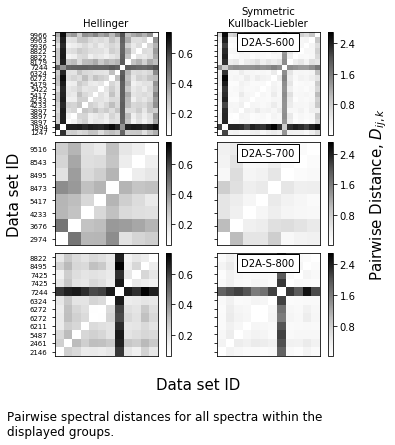

In [19]:
plot_range = [
    "D2A-S-600",
    "D2A-S-700",
    "D2A-S-800",
]

f = mab_project.plot_distance_fig(
    plot_range=plot_range, plot_data=False, ylabel_buffer=0.4, rightlabel_buffer=0.4
)

for ax, label in zip(f.axes[1::2], plot_range):
    ax.text(
        0.5,
        0.95,
        label,
        ha="center",
        va="top",
        transform=ax.transAxes,
        bbox=dict(facecolor="w"),
    )

caption_text = (
    "Pairwise spectral distances for all spectra within the \ndisplayed groups."
)

width, height = f.get_size_inches()

t = f.text(
    0,
    -0.25 / height,
    caption_text,
    size=12,
    va="top",
)

### Save data tables and Interlab project

In [14]:
metadata_table.to_hdf("metadata_table_raw.h5", key="NMR_2D_raw", mode="w")

In [16]:
with open("mAb_interlab_project.sav", "wb") as f:
    pickle.dump(mab_project, f)

In [23]:
with open("mab_analysis_accessories.sav", "wb") as f:
    pickle.dump(
        (windowed_shape, jeffries, full_indices, split_point, ssi_contours, interp_map),
        f,
    )